In [ ]:
!pip3 install -r requirements.txt

## 1 D Regression

In [88]:
# import tensorflow as tf
# from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import torch

import ipywidgets as widgets
from tqdm import tqdm
%matplotlib inline

from sklearn.metrics import mean_squared_error


# from tueplots import bundles
# bundles.icml2022() 
# plt.rcParams.update(bundles.icml2022())

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': r'\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [90]:
latexify()

## Encoder and Decoder Architecture
Encoder takes takes the context X and context y as input 

The output output of Encoder + target X (On which we want predictions, This is mostly a few shot example)

In [91]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output



### Simple Sine Wave

Training data from which we will we taking the context and target during training.

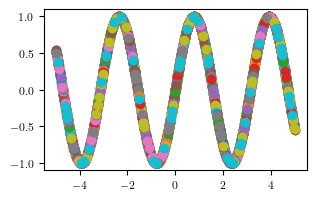

In [92]:
def generate_data_plot(num_samples, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    x = np.random.uniform(-5, 5, num_samples)
    y = amplitude*func(frequency*x + phase_shift)
    plt.scatter(x, y)
    # plt.show()
    return x, y

def generate_data(num_samples, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    x = np.random.uniform(-5, 5, num_samples)
    y =  amplitude*func(frequency*x + phase_shift)
    return x, y

training_data =[generate_data_plot(42, 0, 2, np.sin, 1) for i in range(100)]

In [93]:
import torch.optim as optim

def train(training_data, num_epochs = 1000, num_samples = 42, context_size = 10, target_size = 30):
    # CNP model
    encoder_layout = [[2, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[129, 256], [256, 256], [256, 256], [256, 1]]
    model = CNP(encoder_layout, decoder_layout, torch.relu)


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    
    for epoch in tqdm(range(num_epochs)):
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, len(training_data))


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1,1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # training the model with back propagation
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    return model

During training at every epoch we are taking random context of size context_size and target of target_size from the training_data.

100%|██████████| 1000/1000 [00:02<00:00, 350.44it/s]


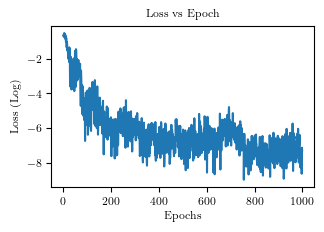

In [94]:
training_data = [generate_data(42) for i in range(100)]
model = train( training_data = training_data, num_epochs = 1000, context_size=10,  target_size=30)

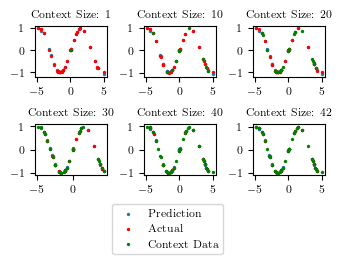

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=[1, 10, 20, 30, 40, 42], phase_shift=0, frequency=1, func=np.sin, amplitude=1):

    test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()

    for i, num_contexts in enumerate(context_sizes):
        # Few-shot context example
        context = np.random.choice(num_samples, num_contexts, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)
        

        # Plot in the current subplot
        ax = axes[i]
        # ax.scatter(target_x, predictions.detach().numpy(), label='Prediction')
        # ax.scatter(target_x, target_y, label="Actual", color='r')
        # ax.scatter(context_x, context_y, label="Context Data", color='g')
        # ax.set_title(f'Context Size: {num_contexts}')
        # ax.tick_params(axis='both', which='both')
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 2)
        ax.scatter(target_x, target_y, label="Actual", color='r', s= 2)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s= 2)
        ax.set_title(f'Context Size: {num_contexts}')
        # ax.tick_params(axis='both', labelsize = 5)
        # ax.legend()

    # Add any additional plots or visualizations if needed

    # Adjust spacing
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04))
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.30, hspace=0.45)
    plt.savefig("plots/sine_prediction.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Example usage with the desired context sizes
testing(model, num_test=32)


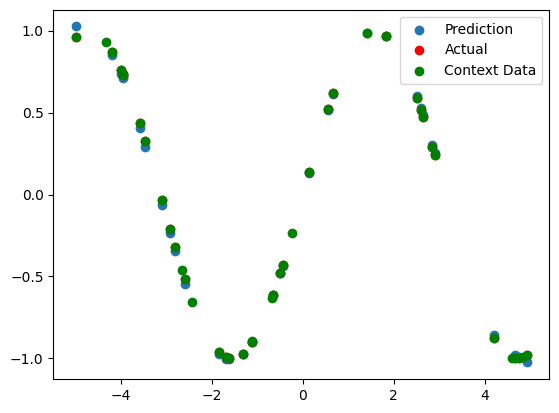

In [7]:

def testing(model, num_samples = 42, num_contexts = 10, num_test = 32, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    

    test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
    # few shot context example
    context=np.random.choice(num_samples, num_contexts, replace=False)
    # predicting on the target
    target=np.random.choice(num_samples, num_test, replace=False)


    target_x=test_data[0][target]
    target_y=test_data[1][target]
    context_x=test_data[0][context]
    context_y=test_data[1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
    predictions = model(context_x, context_y, target_x)

    plt.scatter(target_x, predictions.detach().numpy(), label='Prediction')
    plt.scatter(target_x, target_y, label="Actual", color='r')
    plt.scatter(context_x, context_y, label="Context Data", color='g')
    plt.legend()
    plt.show()

testing(model, num_contexts=42, num_test=32)

# widgets.interact(testing, model = widgets.fixed(model), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


Even with one context point the predictions are fairly close to actual prediction

# Task 2: Training for different Amplitude

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:22<00:00, 449.63it/s]


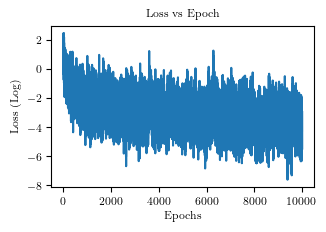

In [95]:

training_data = [generate_data(42, amplitude=np.random.uniform(1, 5)) for i in range(100)]
model2 = train(training_data, 10000)

### Predicting on the random Amplitude

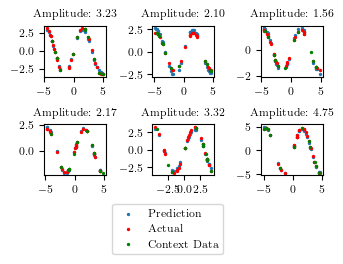

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=12, phase_shift=0, frequency=1, func=np.sin, amplitudes = [1, 2, 3, 4, 5, 8]):

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()

    for i, amplitude in enumerate(amplitudes):
        test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
        # Few-shot context example
        context = np.random.choice(num_samples, context_sizes, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        # Plot in the current subplot
        ax = axes[i]
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 2)
        ax.scatter(target_x, target_y, label="Actual", color='r', s = 2)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s= 2)
        ax.set_title('Amplitude: {:.2f}'.format(amplitude))
        # ax.legend()

    # Add any additional plots or visualizations if needed

    # Adjust spacing
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04))
    plt.tight_layout()
    plt.savefig("plots/1d_regression_random_amplitude.pdf", format = "pdf", bbox_inches = "tight")
    plt.show()

amplitudes = [np.random.random()*4+1 for i in range(6)]
testing(model2, num_test=32, amplitudes=amplitudes)
# widgets.interact(testing, model = widgets.fixed(model2), num_samples = (30, 100, 1), num_contexts = (1, 100, 1

### Impact on Prediction with varying the context size

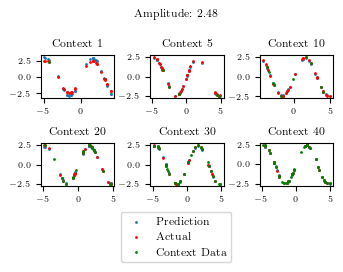

In [133]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=[1, 5, 10, 20, 30, 40], phase_shift=0, frequency=1, func=np.sin, amplitudes = 1 ):


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()
    
    mse_lst = []
    for i, context_size in enumerate(context_sizes):
        test_data = generate_data(num_samples, phase_shift, frequency, func, amplitudes)
        # Few-shot context example
        context = np.random.choice(num_samples, context_size, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        error = torch.mean((target_y - predictions)**2)
        mse_lst.append(error.detach().numpy())
        # Plot in the current subplot
        ax = axes[i]
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 1)
        ax.scatter(target_x, target_y, label="Actual", color='r', s = 1)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s = 1)
        ax.tick_params(axis='both', which='both', labelsize =6)
        ax.set_title('Context {}'.format(context_size))
        # ax.legend()

    # Add any additional plots or visualizations if needed
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04), fontsize = 8)
    fig.suptitle('Amplitude: {:.2f}'.format(amplitudes), fontsize = 8)
    # Adjust spacing
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.30, hspace=0.40)
    plt.savefig("plots/regression_amp.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return mse_lst

amplitudes = [np.random.random()*4+1 for i in range(1)]
mse_lst2 = testing(model2, amplitudes=amplitudes[0])

# widgets.interact(testing, model = widgets.fixed(model2), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


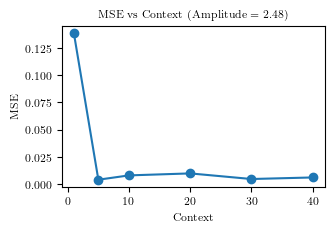

In [134]:
c = [1, 5, 10, 20, 30, 40]
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(c, mse_lst2, marker='o', linestyle='-')
plt.title(f'MSE vs Context  (Amplitude = {amplitudes[0]:.2f})')
plt.xlabel('Context')
plt.ylabel('MSE')
ax.tick_params(axis='both', which='both')
plt.savefig("plots/performance_amp.pdf", format="pdf", bbox_inches="tight")
plt.show()

with 12 context point taken along different amplitude, result we fairly good

### Extrapolating with amplitude

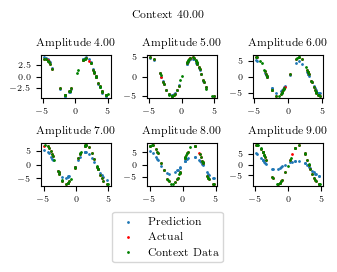

In [108]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=40, phase_shift=0, frequency=1, func=np.sin, amplitudes = 1 ):


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()

    for i, amplitude in enumerate(amplitudes):
        test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
        # Few-shot context example
        context = np.random.choice(num_samples, context_sizes, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        # Plot in the current subplot
        ax = axes[i]
        # ax.set_ylim(-10, )
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 1)
        ax.scatter(target_x, target_y, label="Actual", color='r', s = 1)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s = 1)
        ax.tick_params(axis='both', which='both', labelsize = 6)
        ax.set_title('Amplitude {:.2f}'.format(amplitude, phase_shift))
        # ax.legend()

    # Add any additional plots or visualizations if needed
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04), fontsize = 8)
    fig.suptitle('Context {:.2f}'.format(context_sizes), fontsize = 8)
    # Adjust spacing
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.25, hspace=0.40)

    plt.savefig("plots/extrapolation_amp.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# amplitudes = [np.random.random()*4+4 for i in range(6)]
amplitudes = [4,5, 6,7,8,9]
# phase_shifts = [np.pi/2, np.pi*3, np.pi*1.3, np.pi*1.5, np.pi*2, np.pi*2.4]
testing(model2, amplitudes=amplitudes)


# Task 3: Varying the amplitude and phase

100%|██████████| 10000/10000 [00:19<00:00, 517.66it/s]


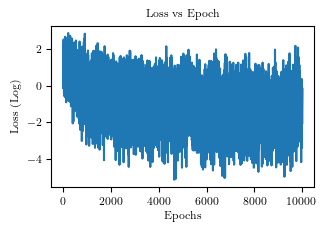

In [109]:

training_data = [generate_data(42, phase_shift=np.random.uniform(0, np.pi), amplitude=np.random.uniform(1, 5)) for i in range(100)]
model3 = train(training_data, 10000)
# widgets.interact(testing, model = widgets.fixed(model3), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


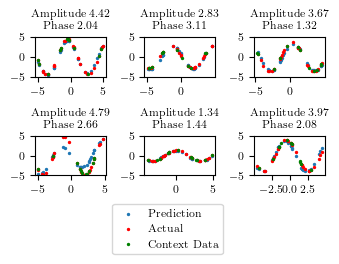

In [78]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=12, phase_shifts = [1,1,1,1,1,1], frequency=1, func=np.sin, amplitudes = [1, 2, 3, 4, 5, 8]):


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()

    for i, (amplitude, phase_shift) in enumerate(zip(amplitudes, phase_shifts)):
        test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
        # Few-shot context example
        context = np.random.choice(num_samples, context_sizes, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        # Plot in the current subplot
        ax = axes[i]
        ax.set_ylim(-5, 5) 
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 2)
        ax.scatter(target_x, target_y, label="Actual", color='r', s=2)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s= 2)
        ax.set_title('Amplitude {:.2f}\nPhase {:.2f}'.format(amplitude, phase_shift))
        # ax.legend()

    # Add any additional plots or visualizations if needed

    # Adjust spacing
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04))
    # Adjust spacing
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.30, hspace=0.40)
    plt.savefig("plots/random_amp_phase.pdf", format="pdf", bbox_inches="tight")
    plt.show()
amplitudes = [np.random.uniform(1, 5) for i in range(6)]
phase_shifts = [np.random.uniform(0, np.pi) for i in range(6)]
testing(model3, num_test=32, amplitudes=amplitudes, phase_shifts=phase_shifts)
# widgets.interact(testing, model = widgets.fixed(model2), num_samples = (30, 100, 1), num_contexts = (1, 100, 1

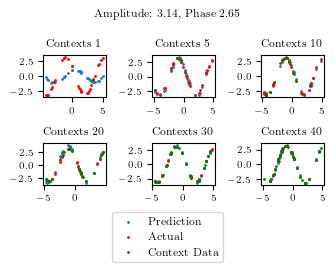

In [121]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes = [1, 5, 10, 20, 30, 40], phase_shifts = 1, frequency=1, func=np.sin, amplitudes = 2):


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()
    mse_lst = []
    
    for i, context_size in enumerate(context_sizes):
        test_data = generate_data(num_samples, phase_shifts, frequency, func, amplitudes)
        # Few-shot context example
        context = np.random.choice(num_samples, context_size, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        error = torch.mean((target_y - predictions)**2)
        mse_lst.append(error.detach().numpy())
        # Plot in the current subplot
        ax = axes[i]
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 1)
        ax.scatter(target_x, target_y, label="Actual", color='r', s = 1)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s = 1)
        ax.tick_params(axis='both', which='both', labelsize=7)
        ax.set_title('Contexts {}'.format(context_size))

    # Add any additional plots or visualizations if needed
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04), fontsize = 8)
    fig.suptitle('Amplitude: {:.2f}, Phase {:.2f}'.format(amplitudes, phase_shifts,), fontsize = 8)
    # Adjust spacing
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.20, hspace=0.40)
    plt.savefig("plots/regression_amp_phase_context.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return mse_lst

amplitudes = [np.random.uniform(1, 5) for i in range(1)]
phase_shifts = [np.random.uniform(0, np.pi) for i in range(1)]
mse_lst3 = testing(model3, amplitudes= amplitudes[0], phase_shifts=phase_shifts[0])
# widgets.interact(testing, model = widgets.fixed(model2), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


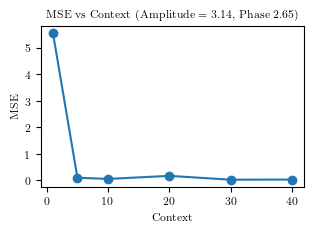

In [122]:
c = [1, 5, 10, 20, 30, 40]
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(c, mse_lst3, marker='o', linestyle='-')
plt.title(f'MSE vs Context (Amplitude = {amplitudes[0]:.2f}, Phase {phase_shifts[0]:.2f}) ')
plt.xlabel('Context')
plt.ylabel('MSE')
# ax.tick_params(axis='both', which='both', labelsize=7)
plt.savefig("plots/performance_amp_phase_.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Extrapolation with phase and Amplitude

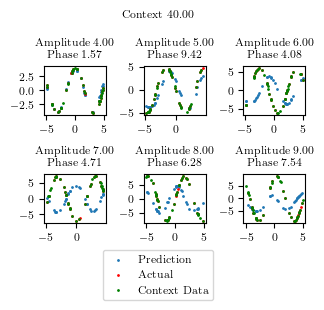

In [130]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def testing(model, num_samples=42, num_test=32, context_sizes=40, phase_shift=0, frequency=1, func=np.sin, amplitudes = 1 ):


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize = (3.2, 2.5))
    axes = axes.flatten()

    for i, (amplitude, phase_shift) in enumerate(zip(amplitudes, phase_shifts)):
        test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
        # Few-shot context example
        context = np.random.choice(num_samples, context_sizes, replace=False)
        # Predicting on the target
        target = np.random.choice(num_samples, num_test, replace=False)

        target_x = test_data[0][target]
        target_y = test_data[1][target]
        context_x = test_data[0][context]
        context_y = test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
        predictions = model(context_x, context_y, target_x)

        # Plot in the current subplot
        ax = axes[i]
        # ax.set_ylim(-10, )
        ax.scatter(target_x, predictions.detach().numpy(), label='Prediction', s = 1)
        ax.scatter(target_x, target_y, label="Actual", color='r', s = 1)
        ax.scatter(context_x, context_y, label="Context Data", color='g', s = 1)
        ax.tick_params(axis='both', which='both')
        ax.set_title('Amplitude {:.2f}\nPhase {:.2f}'.format(amplitude, phase_shift), fontsize = 8)
        # ax.legend()

    # Add any additional plots or visualizations if needed
    fig.legend(loc='upper center', labels=['Prediction', 'Actual', 'Context Data'], bbox_to_anchor=(0.5, 0.04))
    fig.suptitle('Context {:.2f}'.format(context_sizes), fontsize = 8)
    # Adjust spacing
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.25, hspace=0.40)

    plt.savefig("plots/generalise.pdf", format="pdf", bbox_inches="tight")
    plt.show()

amplitudes = [np.random.random()*4+4 for i in range(6)]
amplitudes = [4,5, 6,7,8,9]
phase_shifts = [np.pi/2, np.pi*3, np.pi*1.3, np.pi*1.5, np.pi*2, np.pi*2.4]
testing(model3, amplitudes=amplitudes)
